# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO1: EDA and preprocessing of the datasets

### Importations

Libraries

In [17]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

/Users/hugo/miniconda3/envs/breast-cancer-multimodal/lib/python3.9/site-packages/numpy/_typing/_scalars.py:12: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  _BoolLike_co = Union[bool, np.bool]


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Datasets

### Loading the images

Encontrados 10239 archivos DICOM
Cargada imagen: 1-2.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-2.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-2.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-1.dcm
Cargada imagen: 1-2.dcm


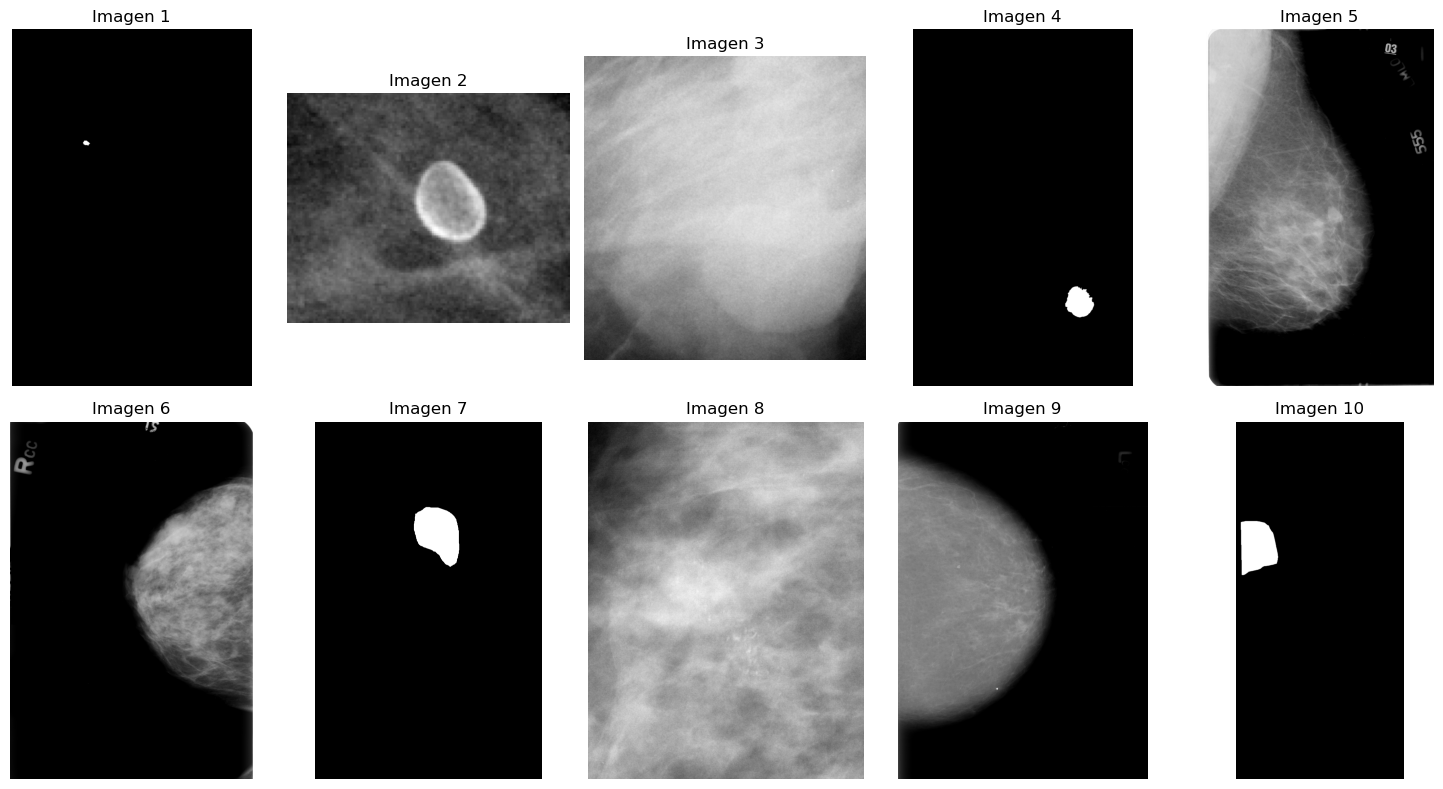

Se cargaron 10 imágenes correctamente


In [14]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# 1. Ruta a tu carpeta CBIS-DDSM
carpeta_dataset = '/Volumes/Proyecto Hugo/breast-cancer-analysis/datasets/CBIS-DDSM'

# 2. Encontrar algunos archivos DICOM (limitados a 10 para comenzar)
archivos_dicom = glob(os.path.join(carpeta_dataset, "**", "*.dcm"), recursive=True)
print(f"Encontrados {len(archivos_dicom)} archivos DICOM")

# 3. Tomar solo los primeros 10 archivos para probar
archivos_muestra = archivos_dicom[:10]

# 4. Cargar estas imágenes
imagenes = []
for archivo in archivos_muestra:
    try:
        # Cargar el archivo DICOM
        dicom = pydicom.dcmread(archivo)
        # Obtener los píxeles de la imagen
        imagen = dicom.pixel_array
        # Normalizar para visualización
        imagen = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
        # Guardar
        imagenes.append(imagen)
        print(f"Cargada imagen: {os.path.basename(archivo)}")
    except Exception as e:
        print(f"Error al cargar {archivo}: {e}")

# 5. Mostrar las imágenes cargadas
plt.figure(figsize=(15, 8))
for i, img in enumerate(imagenes):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Imagen {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Se cargaron {len(imagenes)} imágenes correctamente")